# Part III: Approach B - Fine-tuning an ImageNet Pre-trained CNN 
## Model Selection 

Task:
1. Choose one pre-trained CNN model from torchvision.models (e.g.,
resnet18).
2. Justify your choice: consider factors like the expected trade-off between
model complexity (number of parameters), computational resources
required for training (GPU memory, time), and potential classification
performance.
3. Load your chosen model to get the ImageNet pre-trained weights

In [ ]:
import torch
from torchvision import models
from torchvision.models import ResNet34_Weights

%cd "yourpath"
model = models.resnet34(weights=ResNet34_Weights.DEFAULT)   # Download weights

/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/pfs/data6/home/tu/tu_tu/tu_zxoxe46/Practical Deep Learning/Assignment 2


The chosen model is the "resnet34" because it balances agility and performance: [see CNN benchmarks](https://github.com/jcjohnson/cnn-benchmarks). Looking at the cited benchmarks, and counting on the resources provided by the BW-Cluster, the increase of resource use from "resnet34" wrt the "resnet18" model is quite reasonable (from 31ms to 51ms per batch), since the number of parameters almost doubles and we add from 2-4% of accuracy. On the other hand, "resnet50" improves only by 1-3% while doubling the resources needed wrt resnet34 and more than triples the ones of resnet18.

## Adapting the Classifier Head (The Final Layer): 
Task:
1. Inspect the architecture of your chosen pre-trained model (e.g., by
printing model).

In [92]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

2. Identify the name and characteristics (especially in_features) of its final
classification layer.

In [93]:
print(model.fc.in_features)

512


3. Replace this layer with a new torch.nn.Linear layer that has the correct
number of out_features for your dress categories. 

In [94]:
num_classes = 10 # dresses
model.fc = torch.nn.Linear(model.fc.in_features, num_classes) # Final layer replacement
torch.nn.init.kaiming_normal_(model.fc.weight) # He initialization
print(model.fc)

Linear(in_features=512, out_features=10, bias=True)


## Fine-tuning the Entire Network (Full Fine-tuning) 
### Training:
1. Implement a training and validation loop similar to previous section, but
now your model takes batches of pre-processed images as input, not
dinoV2 feature vectors.

### Imports

In [95]:
!pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [96]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import csv, time, math
import types
from torchvision import models
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torchvision.models import ResNet34_Weights
from torchvision import transforms
from dataclasses import dataclass,field
from typing import Tuple, Dict, List, Literal, Any, Optional
from load_transform import (
    load_data,
    IMG_SIZE,
    IMAGENET_MEAN,
    IMAGENET_STD,
    set_seed,
)
from datetime import datetime
import json
import optuna
from optuna.samplers import GridSampler


### Configuration

In [ ]:
@dataclass
class Config:
    # Datos
    num_workers: int = 4
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    amp: bool = True

    # Training
    epochs:   int = 20
    patience: int = 4
    batch_size: int = 64
    weight_decay: float = 1e-4
    learning_rate: Optional[float]       = None
    scheduler:     Optional[str]         = None
    # Scheduler arguments
    cosine_args: dict        = field(default_factory=lambda: {"T_max": 15, "eta_min": 0})
    plateau_args: dict       = field(default_factory=lambda: {"patience": 2, "factor": 0.2})

    # HyperSearch
    lr_values: List[float] = field(default_factory=lambda:[5e-4, 1e-4, 5e-5, 1e-5])
    scheduler_choices: List[str]= field(default_factory=lambda:["cosine", "plateau"])

    # Future applications
    # backbone_lr_mult: float = 0.10
    # unfreeze_at_epoch: dict[int, list[str]] = field(default_factory=dict)

    # Model
    num_classes: int = 10
    pretrained_weights = ResNet34_Weights.DEFAULT
    freeze_backbone: bool = True

    # Helpers
    # @property
    # def lr_backbone(self) -> float:
    #     return self.learning_rate * self.backbone_lr_mult
    
cfg = Config()

### Load data

In [ ]:
train_loader, val_loader, test_loader, label_to_idx = load_data(batch_size=64,num_workers=cfg.num_workers,seed=cfg.seed)
print(f"Classes: {len(label_to_idx)} | Train: {len(train_loader.dataset)} | "f"Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}")

Classes: 10 | Train: 10821 | Val: 2706 | Test: 3382


### Model Class

In [ ]:
class DressNet34(nn.Module):
    def __init__(self, cfg: Config | dict, freeze_backbone: bool = True):
        super().__init__()

        # hyper-param helper
        _get = (lambda k, d=None:
                cfg[k] if isinstance(cfg, dict) else getattr(cfg, k, d))

        self.num_classes = _get("num_classes")
        if self.num_classes is None:
            raise ValueError("`cfg` must define `num_classes`")

        #backbone + new head
        weights   = _get("pretrained_weights", ResNet34_Weights.DEFAULT)
        self.backbone = models.resnet34(weights=weights)

        in_feats  = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, self.num_classes)

        # He initialisation
        nn.init.kaiming_normal_(self.backbone.fc.weight, nonlinearity="relu")
        nn.init.zeros_(self.backbone.fc.bias)

        if freeze_backbone:
            self.freeze()

    # Forward pass
    def forward(self, x):
        return self.backbone(x)

    # freezing
    def freeze(self) -> None:
        for p in self.backbone.parameters():
            p.requires_grad = False
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    # def unfreeze_block(self, block_name: str):
    #     enable = False
    #     for name, module in self.backbone.named_children():
    #         if name == block_name:
    #             enable = True
    #         if enable or name == "fc":
    #             for p in module.parameters():
    #                 p.requires_grad = True

    # utils
    def trainable_parameters(self):
        return (p for p in self.parameters() if p.requires_grad)

    def count_params(self, trainable_only: bool = True):
        params = self.trainable_parameters() if trainable_only else self.parameters()
        return sum(p.numel() for p in params)

    def save_weights(self, path: str | Path):
        torch.save(self.state_dict(), Path(path))

    def load_weights(self, path: str | Path, map_location="cpu"):
        self.load_state_dict(torch.load(path, map_location=map_location))

### Traning Loop that wraps the model class. 
I started implementing gradual unfreezing by error because I understood the task wrong. I didn't delete the code because i took too much work.

2. Use an appropriate loss function (e.g., CrossEntropyLoss) and optimizer.
3. Employ early stopping based on validation performance.

In [ ]:
class Trainer:
    def __init__(self, model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, cfg, run_dir: Path,
    ) -> None:
        self.cfg = cfg
        self.device = torch.device(cfg.device)
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        # Optimizer for both lr_backbone and head
        # head_params = model.backbone.fc.parameters()
        # backbone_params = [p for n, p in model.backbone.named_parameters()
        #                     if not n.startswith("fc") and p.requires_grad]
        # param_groups = [{"params": head_params, "lr": cfg.learning_rate}]
        self.optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
        if cfg.scheduler == "cosine":
            self.scheduler = CosineAnnealingLR(self.optimizer, **cfg.cosine_args)
        elif cfg.scheduler == "plateau":
            self.scheduler = ReduceLROnPlateau(self.optimizer, **cfg.plateau_args)
        else:
            self.scheduler = None
        self.scheduler_name = cfg.scheduler  # para logs

        # not used
        # if backbone_params:
        #     param_groups.insert(0, {"params": backbone_params,
        #                             "lr": cfg.lr_backbone})        

        # Adecuate loss
        self.criterion = nn.CrossEntropyLoss()
        self.scaler = GradScaler(enabled=cfg.amp)

        # CSV
        run_dir.mkdir(parents=True, exist_ok=True)
        self.writer = SummaryWriter(log_dir=run_dir)
        self.csv_path = run_dir / "metrics.csv"
        with open(self.csv_path, "w", newline="") as f:
            csv.writer(f).writerow(
                ["epoch", "train_loss", "train_acc", "val_loss",
                 "val_acc", "lr_sched", "scheduler_type"]
            )

    # def _maybe_unfreeze(self, epoch: int) -> None:
    #     layers = self.cfg.unfreeze_at_epoch.get(epoch, [])
    #     if not layers:
    #         return
    #     for layer in layers:
    #         self.model.unfreeze_block(layer)
    #     currently_in_opt = {id(p) for g in self.optimizer.param_groups for p in g["params"]}
    #     fresh_params = [p for p in self.model.backbone.parameters()
    #                     if p.requires_grad and id(p) not in currently_in_opt]
    #     if fresh_params:
    #         self.optimizer.add_param_group({"params": fresh_params, "lr": self.cfg.lr_backbone})

    def _run_epoch(self) -> Tuple[float, float]:
        self.model.train()
        losses, correct, total = 0.0, 0, 0
        for X, y in self.train_loader:
            X, y = X.to(self.device), y.to(self.device)
            self.optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=self.device.type, enabled=self.cfg.amp):
                logits = self.model(X)
                loss = self.criterion(logits, y)
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            losses += loss.item() * X.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += X.size(0)
        return losses / total, correct / total

    @torch.no_grad()
    def _validate(self) -> Tuple[float, float]:
        self.model.eval()
        losses, correct, total = 0.0, 0, 0
        for X, y in self.val_loader:
            X, y = X.to(self.device), y.to(self.device)
            with autocast(device_type = self.device.type, enabled=self.cfg.amp):
                logits = self.model(X)
                loss = self.criterion(logits, y)
            losses += loss.item() * X.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += X.size(0)
        return losses / total, correct / total

    def train(self) -> Dict[str, float]:
        best_val_loss, patience_ctr, best_state = math.inf, 0, None

        for epoch in range(1, self.cfg.epochs + 1):
            tic = time.time()
            # self._maybe_unfreeze(epoch)

            train_loss, train_acc = self._run_epoch()
            val_loss, val_acc     = self._validate()

            if self.scheduler_name == "cosine":
                self.scheduler.step()
            elif self.scheduler_name == "plateau":
                self.scheduler.step(val_loss)

            lr_now = self.optimizer.param_groups[0]["lr"]

            # lr_head     = self.optimizer.param_groups[-1]["lr"]          # último grupo = head
            # lr_backbone = next((g["lr"] for g in self.optimizer.param_groups
            #                     if g["lr"] != lr_head), 0.0)             # 0.0 si no existe (robusto)

            # logs
            self.writer.add_scalars("Loss", {"train": train_loss,
                                             "val":   val_loss}, epoch)
            self.writer.add_scalars("Acc", {"train": train_acc,
                                            "val":   val_acc}, epoch)
            self.writer.add_scalar("LR/scheduler", lr_now, epoch)

            with open(self.csv_path, "a", newline="") as f:
                csv.writer(f).writerow(
                    [epoch, train_loss, train_acc, val_loss,
                     val_acc, lr_now, self.scheduler_name or "none"]
                )

            print(
                f"ep {epoch:03d} | "
                f"tr_loss {train_loss:.4f} val_loss {val_loss:.4f} | "
                f"tr_acc {train_acc:.4f} val_acc {val_acc:.4f} | "
                f"lr {lr_now:.2e} | {time.time()-tic:.1f}s"
            )

            # early stopping
            if val_loss < best_val_loss:
                best_val_loss, patience_ctr = val_loss, 0
                best_state = self.model.state_dict()
            else:
                patience_ctr += 1
                if patience_ctr >= self.cfg.patience:
                    print("Early stopping")
                    break

        # checkpoint
        if best_state:
            torch.save({
                "epoch": epoch,
                "best_val_loss": best_val_loss,
                "model_state": best_state,
                "optim_state": self.optimizer.state_dict(),
                "sched_state": (self.scheduler.state_dict() if self.scheduler else None)
            }, Path(self.writer.log_dir) / "checkpoint.pt")
        self.writer.flush(); self.writer.close()
        return {"best_val_loss": best_val_loss,
                "best_train_loss": train_loss,
                "best_val_acc": val_acc,
                "best_train_acc": train_acc,
                "scheduler": self.scheduler_name,
                "log_dir": str(self.writer.log_dir)}

    def predict(self, loader: DataLoader) -> torch.Tensor:
        self.model.eval()
        preds = []
        with torch.no_grad():
            for X, _ in loader:
                X = X.to(self.device)
                with autocast(device_type=self.device.type, enabled=self.cfg.amp):
                    logits = self.model(X)
                preds.append(logits.argmax(1).cpu())
        return torch.cat(preds)

We test the trainer by running 1 epoch only training the output layer.

In [101]:
run_dir = Path("runs/part3_onlytrainhead")
cfg = Config(epochs=1, learning_rate=1e-3)
model   = DressNet34(cfg, freeze_backbone=cfg.freeze_backbone)
print(f"Trainable params: {model.count_params(trainable_only=True):,}")
print(f"Params: {model.count_params(trainable_only=False):,}")

trainer = Trainer(model, train_loader, val_loader, cfg, run_dir)
summary = trainer.train()
print(summary)

Trainable params: 5,130
Params: 21,289,802
ep 001 | tr_loss 1.8940 val_loss 1.6207 | tr_acc 0.3502 val_acc 0.4287 | lr 1.00e-03 | 57.4s
{'best_val_loss': 1.6207276970390383, 'best_train_loss': 1.894002810245895, 'best_val_acc': 0.4286770140428677, 'best_train_acc': 0.3501524812863876, 'scheduler': None, 'log_dir': 'runs/part3_onlytrainhead'}


We run another epoch testing the Full Fine-Tuning

In [102]:
run_dir = Path("runs/part3_onlytrainfull")
cfg = Config(epochs=1, freeze_backbone=False, learning_rate=1e-5)
model   = DressNet34(cfg, freeze_backbone=cfg.freeze_backbone)
print(f"Trainable params: {model.count_params(trainable_only=True):,}")
print(f"Params: {model.count_params(trainable_only=False):,}")

trainer = Trainer(model, train_loader, val_loader, cfg, run_dir)
summary = trainer.train()
print(summary)

Trainable params: 21,289,802
Params: 21,289,802
ep 001 | tr_loss 1.7759 val_loss 1.3926 | tr_acc 0.4354 val_acc 0.5296 | lr 1.00e-05 | 59.1s
{'best_val_loss': 1.3925972011295495, 'best_train_loss': 1.7758569811708262, 'best_val_acc': 0.5295639320029564, 'best_train_acc': 0.43544958876259127, 'scheduler': None, 'log_dir': 'runs/part3_onlytrainfull'}


4. For hyperparameter tuning primarily focus on: 

- Learning Rate: Start with your chosen optimizer (e.g., Adam) and a
common batch size (e.g., 32). Experiment systematically with different
learning rates (e.g., 5e-4, 1e-4, 5e-5, 1e-5). Plot validation accuracy/loss
curves for these LR trials.
- Learning Rate Scheduler: Once you have a good constant LR, apply one
l e a r n i n g r a t e s c h e d u l e r ( e . g . , R e d u c e L R O n P l a t e a u o r
CosineAnnealingLR) to see if it improves convergence or final
performance. Compare validation curves. 

### Hyperparameter Search Module
This will be the method that performs hyperparameter search wrapping the trainer module. In this case we don't implement ASHA but a classic grid search because we only want to tune two hyperparameters and the training time per epoch is higher in this case. Therefore, a more simple and less-exhaustive search will save time and computation resources compared to are more advanced, automatized and comprehensive bandit-based method.

Therefore, this method performs Hyperparameter search as stated in the instructions in two sequential steps:
1. Select an adequate learning rate from a discrete set of options
2. Fix the best learning rate and try one of the learning rate schedulers

In [ ]:
class HyperSearch:
    def __init__(self, cfg: Config, *, base_dir: str = "runs/part3"):
        set_seed(cfg.seed)
        self.cfg = cfg
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(parents=True, exist_ok=True)
        self.device = torch.device(cfg.device)

    def _make_loaders(self):
        return load_data(
            batch_size   = self.cfg.batch_size,
            num_workers  = self.cfg.num_workers,
            seed         = self.cfg.seed,
        )[:2]

    def _objective_lr(self, trial: optuna.Trial) -> float:
        lr = trial.suggest_categorical("lr", self.cfg.lr_values)
        cfg = Config(**vars(self.cfg))
        cfg.learning_rate = lr
        cfg.scheduler     = None

        trn, vld = self._make_loaders()
        model    = DressNet34(cfg, freeze_backbone=False).to(self.device)
        run_dir  = self.base_dir/f"lr_{lr:.0e}"
        stats    = Trainer(model, trn, vld, cfg, run_dir).train()
        return stats["best_val_loss"]

    def _objective_sched(self, trial: optuna.Trial, fixed: dict) -> float:
        lr    = fixed["lr"]
        sched = trial.suggest_categorical("scheduler", self.cfg.scheduler_choices)
        
        cfg = Config(**vars(self.cfg))
        cfg.learning_rate = lr
        cfg.scheduler     = sched
        
        trn, vld = self._make_loaders()
        model    = DressNet34(cfg, freeze_backbone=False).to(self.device)
        run_dir  = self.base_dir/f"sched_{sched}_lr{lr:.0e}"
        stats    = Trainer(model, trn, vld, cfg, run_dir).train()
        return stats["best_val_loss"]

    def run(self):
        # lr_values
        sampler1 = optuna.samplers.GridSampler({"lr": self.cfg.lr_values})
        study1  = optuna.create_study(direction="minimize", sampler=sampler1)
        study1.optimize(self._objective_lr)
        best1  = study1.best_trial.params
        with open(self.base_dir/"phase1.json","w") as f: json.dump(best1,f)

        # scheduler_choices
        sampler2 = optuna.samplers.GridSampler({"scheduler": self.cfg.scheduler_choices})
        study2  = optuna.create_study(direction="minimize", sampler=sampler2)
        study2.optimize(lambda t: self._objective_sched(t, best1))
        best2  = study2.best_trial.params
        with open(self.base_dir/"phase2.json","w") as f: json.dump(best2,f)

        return {"phase1": best1, "phase2": best2}


We start the Hyper-parameter search

In [104]:
cfg = Config(freeze_backbone=False)
print(cfg)

# Only for debugging
model   = DressNet34(cfg, freeze_backbone=cfg.freeze_backbone)
print(f"Trainable params: {model.count_params(trainable_only=True):,}")
print(f"Params: {model.count_params(trainable_only=False):,}")
# If Trainable params = params, then we have full fine-tuning. Now we run
hs = HyperSearch(cfg, base_dir="runs/part3_15epochs")
hs.run()

Config(num_workers=4, seed=42, device='cuda', amp=True, epochs=15, patience=6, batch_size=64, weight_decay=0.0001, learning_rate=None, scheduler=None, cosine_args={'T_max': 15, 'eta_min': 0}, plateau_args={'patience': 1, 'factor': 0.2}, lr_values=[0.0005, 0.0001, 5e-05, 1e-05], scheduler_choices=['cosine', 'plateau'], num_classes=10, freeze_backbone=False)


[I 2025-06-17 12:00:08,586] A new study created in memory with name: no-name-7f3aac78-fa65-4e07-909a-e834879dd18e


Trainable params: 21,289,802
Params: 21,289,802
ep 001 | tr_loss 1.5143 val_loss 1.1716 | tr_acc 0.5040 val_acc 0.5813 | lr 5.00e-05 | 58.3s
ep 002 | tr_loss 0.9706 val_loss 1.1626 | tr_acc 0.6547 val_acc 0.6013 | lr 5.00e-05 | 59.3s
ep 003 | tr_loss 0.6827 val_loss 1.2493 | tr_acc 0.7602 val_acc 0.5902 | lr 5.00e-05 | 60.1s
ep 004 | tr_loss 0.4005 val_loss 1.3872 | tr_acc 0.8620 val_acc 0.5957 | lr 5.00e-05 | 60.6s
ep 005 | tr_loss 0.2105 val_loss 1.7267 | tr_acc 0.9352 val_acc 0.5809 | lr 5.00e-05 | 60.5s
ep 006 | tr_loss 0.1688 val_loss 1.7078 | tr_acc 0.9455 val_acc 0.6061 | lr 5.00e-05 | 60.7s
ep 007 | tr_loss 0.0669 val_loss 1.8684 | tr_acc 0.9818 val_acc 0.5905 | lr 5.00e-05 | 58.9s
ep 008 | tr_loss 0.0382 val_loss 2.0206 | tr_acc 0.9916 val_acc 0.6057 | lr 5.00e-05 | 59.4s
Early stopping


[I 2025-06-17 12:08:06,914] Trial 0 finished with value: 1.1626415223610111 and parameters: {'lr': 5e-05}. Best is trial 0 with value: 1.1626415223610111.


ep 001 | tr_loss 2.1490 val_loss 1.4578 | tr_acc 0.3764 val_acc 0.5137 | lr 1.00e-05 | 58.2s
ep 002 | tr_loss 1.2555 val_loss 1.2831 | tr_acc 0.5746 val_acc 0.5580 | lr 1.00e-05 | 60.7s
ep 003 | tr_loss 1.0170 val_loss 1.2432 | tr_acc 0.6523 val_acc 0.5861 | lr 1.00e-05 | 60.8s
ep 004 | tr_loss 0.8239 val_loss 1.2630 | tr_acc 0.7243 val_acc 0.5806 | lr 1.00e-05 | 60.6s
ep 005 | tr_loss 0.6482 val_loss 1.2802 | tr_acc 0.7949 val_acc 0.5824 | lr 1.00e-05 | 59.4s
ep 006 | tr_loss 0.4945 val_loss 1.2980 | tr_acc 0.8556 val_acc 0.5780 | lr 1.00e-05 | 58.0s
ep 007 | tr_loss 0.3573 val_loss 1.4093 | tr_acc 0.9080 val_acc 0.5772 | lr 1.00e-05 | 57.7s
ep 008 | tr_loss 0.2418 val_loss 1.4346 | tr_acc 0.9501 val_acc 0.5831 | lr 1.00e-05 | 57.7s
ep 009 | tr_loss 0.1635 val_loss 1.5194 | tr_acc 0.9742 val_acc 0.5780 | lr 1.00e-05 | 58.2s
Early stopping


[I 2025-06-17 12:16:58,741] Trial 1 finished with value: 1.2432110797715734 and parameters: {'lr': 1e-05}. Best is trial 0 with value: 1.1626415223610111.


ep 001 | tr_loss 1.4099 val_loss 1.2189 | tr_acc 0.5195 val_acc 0.5732 | lr 1.00e-04 | 58.9s
ep 002 | tr_loss 0.9873 val_loss 1.1112 | tr_acc 0.6486 val_acc 0.6098 | lr 1.00e-04 | 59.8s
ep 003 | tr_loss 0.7681 val_loss 1.2661 | tr_acc 0.7272 val_acc 0.5728 | lr 1.00e-04 | 59.9s
ep 004 | tr_loss 0.5483 val_loss 1.3469 | tr_acc 0.8063 val_acc 0.5843 | lr 1.00e-04 | 60.1s
ep 005 | tr_loss 0.3534 val_loss 1.6563 | tr_acc 0.8752 val_acc 0.5632 | lr 1.00e-04 | 59.7s
ep 006 | tr_loss 0.2582 val_loss 1.7106 | tr_acc 0.9100 val_acc 0.5880 | lr 1.00e-04 | 60.0s
ep 007 | tr_loss 0.1423 val_loss 2.0489 | tr_acc 0.9529 val_acc 0.5957 | lr 1.00e-04 | 60.3s
ep 008 | tr_loss 0.2220 val_loss 2.2287 | tr_acc 0.9214 val_acc 0.5510 | lr 1.00e-04 | 59.4s
Early stopping


[I 2025-06-17 12:24:57,474] Trial 2 finished with value: 1.1112036990485012 and parameters: {'lr': 0.0001}. Best is trial 2 with value: 1.1112036990485012.


ep 001 | tr_loss 1.4151 val_loss 1.3693 | tr_acc 0.5016 val_acc 0.5340 | lr 5.00e-04 | 58.7s
ep 002 | tr_loss 1.1542 val_loss 1.1692 | tr_acc 0.5827 val_acc 0.5880 | lr 5.00e-04 | 60.1s
ep 003 | tr_loss 1.0408 val_loss 1.3187 | tr_acc 0.6264 val_acc 0.5285 | lr 5.00e-04 | 59.7s
ep 004 | tr_loss 0.9195 val_loss 1.1804 | tr_acc 0.6672 val_acc 0.5913 | lr 5.00e-04 | 59.7s
ep 005 | tr_loss 0.7990 val_loss 1.2602 | tr_acc 0.7143 val_acc 0.5558 | lr 5.00e-04 | 59.8s
ep 006 | tr_loss 0.6752 val_loss 1.5929 | tr_acc 0.7599 val_acc 0.5421 | lr 5.00e-04 | 60.4s
ep 007 | tr_loss 0.5800 val_loss 1.3175 | tr_acc 0.7959 val_acc 0.5939 | lr 5.00e-04 | 61.1s
ep 008 | tr_loss 0.4293 val_loss 1.4482 | tr_acc 0.8497 val_acc 0.5854 | lr 5.00e-04 | 59.5s
Early stopping


[I 2025-06-17 12:32:57,195] Trial 3 finished with value: 1.1692225479321927 and parameters: {'lr': 0.0005}. Best is trial 2 with value: 1.1112036990485012.
[I 2025-06-17 12:32:57,201] A new study created in memory with name: no-name-bf864865-4224-45e7-bf46-5de3c7919a40


ep 001 | tr_loss 1.4099 val_loss 1.2189 | tr_acc 0.5195 val_acc 0.5732 | lr 1.00e-04 | 60.4s
ep 002 | tr_loss 0.9873 val_loss 1.1112 | tr_acc 0.6486 val_acc 0.6098 | lr 1.00e-04 | 61.8s
ep 003 | tr_loss 0.7681 val_loss 1.2661 | tr_acc 0.7272 val_acc 0.5728 | lr 1.00e-04 | 60.8s
ep 004 | tr_loss 0.5483 val_loss 1.3469 | tr_acc 0.8063 val_acc 0.5843 | lr 2.00e-05 | 59.6s
ep 005 | tr_loss 0.1893 val_loss 1.4212 | tr_acc 0.9440 val_acc 0.6227 | lr 2.00e-05 | 60.4s
ep 006 | tr_loss 0.0679 val_loss 1.5996 | tr_acc 0.9873 val_acc 0.6194 | lr 4.00e-06 | 59.4s
ep 007 | tr_loss 0.0291 val_loss 1.6346 | tr_acc 0.9981 val_acc 0.6323 | lr 4.00e-06 | 59.1s
ep 008 | tr_loss 0.0237 val_loss 1.6488 | tr_acc 0.9988 val_acc 0.6245 | lr 8.00e-07 | 59.0s
Early stopping


[I 2025-06-17 12:40:58,336] Trial 0 finished with value: 1.1112036990485012 and parameters: {'scheduler': 'plateau'}. Best is trial 0 with value: 1.1112036990485012.


ep 001 | tr_loss 1.4099 val_loss 1.2189 | tr_acc 0.5195 val_acc 0.5732 | lr 9.89e-05 | 58.4s
ep 002 | tr_loss 0.9854 val_loss 1.1131 | tr_acc 0.6486 val_acc 0.6057 | lr 9.57e-05 | 59.9s
ep 003 | tr_loss 0.7556 val_loss 1.2698 | tr_acc 0.7270 val_acc 0.5665 | lr 9.05e-05 | 59.2s
ep 004 | tr_loss 0.5014 val_loss 1.3661 | tr_acc 0.8237 val_acc 0.5994 | lr 8.35e-05 | 60.8s
ep 005 | tr_loss 0.2878 val_loss 1.6601 | tr_acc 0.8974 val_acc 0.5831 | lr 7.50e-05 | 61.0s
ep 006 | tr_loss 0.1756 val_loss 1.7002 | tr_acc 0.9402 val_acc 0.5994 | lr 6.55e-05 | 59.0s
ep 007 | tr_loss 0.0679 val_loss 1.9253 | tr_acc 0.9796 val_acc 0.6098 | lr 5.52e-05 | 60.7s
ep 008 | tr_loss 0.0312 val_loss 2.0029 | tr_acc 0.9919 val_acc 0.6197 | lr 4.48e-05 | 60.1s
Early stopping


[I 2025-06-17 12:48:58,199] Trial 1 finished with value: 1.1131090476437138 and parameters: {'scheduler': 'cosine'}. Best is trial 0 with value: 1.1112036990485012.


{'phase1': {'lr': 0.0001}, 'phase2': {'scheduler': 'plateau'}}

In [ ]:
cfg = Config(freeze_backbone=False)
print(cfg)

# Only for debugging
model   = DressNet34(cfg, freeze_backbone=cfg.freeze_backbone)
print(f"Trainable params: {model.count_params(trainable_only=True):,}")
print(f"Params: {model.count_params(trainable_only=False):,}")
# If Trainable params = params, then we have full fine-tuning. Now we run
hs = HyperSearch(cfg, base_dir="runs/part3_20epochs")
hs.run()

Config(num_workers=4, seed=42, device='cuda', amp=True, epochs=20, patience=4, batch_size=128, weight_decay=0.0001, learning_rate=None, scheduler=None, cosine_args={'T_max': 20, 'eta_min': 1e-07}, plateau_args={'patience': 2, 'factor': 0.2}, lr_values=[0.0005, 0.0001, 5e-05, 1e-05, 5e-06], scheduler_choices=['cosine', 'plateau'], num_classes=10, freeze_backbone=False)


[I 2025-06-17 10:22:49,087] A new study created in memory with name: no-name-102fd290-89b7-41d0-a284-70d9fcd11940


Trainable params: 21,289,802
Params: 21,289,802
ep 001 | tr_loss 1.6383 val_loss 1.2187 | tr_acc 0.4821 val_acc 0.5780 | lr 5.00e-05 | 59.9s
ep 002 | tr_loss 0.9685 val_loss 1.2349 | tr_acc 0.6550 val_acc 0.5783 | lr 5.00e-05 | 60.2s
ep 003 | tr_loss 0.6499 val_loss 1.2075 | tr_acc 0.7746 val_acc 0.6024 | lr 5.00e-05 | 60.4s
ep 004 | tr_loss 0.3429 val_loss 1.3781 | tr_acc 0.8979 val_acc 0.5887 | lr 5.00e-05 | 58.9s
ep 005 | tr_loss 0.1377 val_loss 1.5315 | tr_acc 0.9689 val_acc 0.5950 | lr 5.00e-05 | 60.2s
ep 006 | tr_loss 0.0518 val_loss 1.6806 | tr_acc 0.9929 val_acc 0.5857 | lr 5.00e-05 | 59.3s
ep 007 | tr_loss 0.0177 val_loss 1.7924 | tr_acc 0.9991 val_acc 0.6024 | lr 5.00e-05 | 60.8s
Early stopping


[I 2025-06-17 10:29:49,384] Trial 0 finished with value: 1.207488491371307 and parameters: {'lr': 5e-05}. Best is trial 0 with value: 1.207488491371307.


ep 001 | tr_loss 1.4210 val_loss 1.3227 | tr_acc 0.5092 val_acc 0.5351 | lr 5.00e-04 | 60.4s
ep 002 | tr_loss 1.1032 val_loss 1.2018 | tr_acc 0.6002 val_acc 0.5780 | lr 5.00e-04 | 59.5s
ep 003 | tr_loss 0.9598 val_loss 1.2534 | tr_acc 0.6523 val_acc 0.5536 | lr 5.00e-04 | 61.8s
ep 004 | tr_loss 0.8372 val_loss 1.2746 | tr_acc 0.7022 val_acc 0.5466 | lr 5.00e-04 | 59.3s
ep 005 | tr_loss 0.6972 val_loss 1.2709 | tr_acc 0.7529 val_acc 0.5872 | lr 5.00e-04 | 59.1s
ep 006 | tr_loss 0.5751 val_loss 1.3523 | tr_acc 0.7942 val_acc 0.5820 | lr 5.00e-04 | 59.0s
Early stopping


[I 2025-06-17 10:35:49,154] Trial 1 finished with value: 1.2018212956670296 and parameters: {'lr': 0.0005}. Best is trial 1 with value: 1.2018212956670296.


ep 002 | tr_loss 0.9599 val_loss 1.1364 | tr_acc 0.6574 val_acc 0.6120 | lr 1.00e-04 | 61.1s
ep 003 | tr_loss 0.6849 val_loss 1.2792 | tr_acc 0.7562 val_acc 0.5772 | lr 1.00e-04 | 60.9s
ep 004 | tr_loss 0.4137 val_loss 1.5277 | tr_acc 0.8515 val_acc 0.5758 | lr 1.00e-04 | 59.4s
ep 005 | tr_loss 0.2155 val_loss 1.7047 | tr_acc 0.9299 val_acc 0.5791 | lr 1.00e-04 | 58.9s
ep 006 | tr_loss 0.1513 val_loss 1.8243 | tr_acc 0.9506 val_acc 0.5831 | lr 1.00e-04 | 59.8s
Early stopping


[I 2025-06-17 10:41:50,089] Trial 2 finished with value: 1.1363938877693565 and parameters: {'lr': 0.0001}. Best is trial 2 with value: 1.1363938877693565.


ep 001 | tr_loss 2.4357 val_loss 1.6067 | tr_acc 0.3207 val_acc 0.4760 | lr 1.00e-05 | 59.9s
ep 002 | tr_loss 1.3920 val_loss 1.3647 | tr_acc 0.5445 val_acc 0.5355 | lr 1.00e-05 | 61.0s
ep 003 | tr_loss 1.1257 val_loss 1.3021 | tr_acc 0.6204 val_acc 0.5610 | lr 1.00e-05 | 59.9s
ep 004 | tr_loss 0.9434 val_loss 1.2786 | tr_acc 0.6827 val_acc 0.5702 | lr 1.00e-05 | 61.0s
ep 005 | tr_loss 0.7841 val_loss 1.2687 | tr_acc 0.7439 val_acc 0.5706 | lr 1.00e-05 | 59.9s
ep 006 | tr_loss 0.6357 val_loss 1.3040 | tr_acc 0.8048 val_acc 0.5717 | lr 1.00e-05 | 60.4s
ep 007 | tr_loss 0.5030 val_loss 1.3418 | tr_acc 0.8629 val_acc 0.5758 | lr 1.00e-05 | 60.6s
ep 008 | tr_loss 0.3780 val_loss 1.4076 | tr_acc 0.9082 val_acc 0.5735 | lr 1.00e-05 | 60.2s
ep 009 | tr_loss 0.2697 val_loss 1.4631 | tr_acc 0.9487 val_acc 0.5691 | lr 1.00e-05 | 60.0s
Early stopping


[I 2025-06-17 10:50:53,672] Trial 3 finished with value: 1.2686584543847015 and parameters: {'lr': 1e-05}. Best is trial 2 with value: 1.1363938877693565.


ep 001 | tr_loss 2.9395 val_loss 2.0781 | tr_acc 0.2138 val_acc 0.3699 | lr 5.00e-06 | 58.8s
ep 002 | tr_loss 1.7887 val_loss 1.6116 | tr_acc 0.4574 val_acc 0.4823 | lr 5.00e-06 | 61.4s
ep 003 | tr_loss 1.4285 val_loss 1.4526 | tr_acc 0.5408 val_acc 0.5214 | lr 5.00e-06 | 61.6s
ep 004 | tr_loss 1.2393 val_loss 1.3706 | tr_acc 0.5877 val_acc 0.5399 | lr 5.00e-06 | 61.8s
ep 005 | tr_loss 1.1079 val_loss 1.3253 | tr_acc 0.6264 val_acc 0.5514 | lr 5.00e-06 | 59.0s
ep 006 | tr_loss 1.0014 val_loss 1.2995 | tr_acc 0.6607 val_acc 0.5625 | lr 5.00e-06 | 59.4s
ep 007 | tr_loss 0.9091 val_loss 1.2945 | tr_acc 0.6992 val_acc 0.5650 | lr 5.00e-06 | 61.0s
ep 008 | tr_loss 0.8168 val_loss 1.2967 | tr_acc 0.7317 val_acc 0.5661 | lr 5.00e-06 | 61.2s
ep 009 | tr_loss 0.7290 val_loss 1.3144 | tr_acc 0.7695 val_acc 0.5706 | lr 5.00e-06 | 58.7s
ep 010 | tr_loss 0.6449 val_loss 1.3189 | tr_acc 0.8073 val_acc 0.5654 | lr 5.00e-06 | 61.6s
ep 011 | tr_loss 0.5691 val_loss 1.3314 | tr_acc 0.8389 val_acc 0.5661

[I 2025-06-17 11:01:59,514] Trial 4 finished with value: 1.2945088782490224 and parameters: {'lr': 5e-06}. Best is trial 2 with value: 1.1363938877693565.
[I 2025-06-17 11:01:59,520] A new study created in memory with name: no-name-19e3b65a-6d18-4a18-b861-174bf0c4a713


ep 001 | tr_loss 1.4938 val_loss 1.1553 | tr_acc 0.5120 val_acc 0.5928 | lr 1.00e-04 | 59.6s
ep 002 | tr_loss 0.9599 val_loss 1.1364 | tr_acc 0.6574 val_acc 0.6120 | lr 1.00e-04 | 61.1s
ep 003 | tr_loss 0.6849 val_loss 1.2792 | tr_acc 0.7562 val_acc 0.5772 | lr 1.00e-04 | 59.7s
ep 004 | tr_loss 0.4137 val_loss 1.5277 | tr_acc 0.8515 val_acc 0.5758 | lr 1.00e-04 | 59.9s
ep 005 | tr_loss 0.2155 val_loss 1.7047 | tr_acc 0.9299 val_acc 0.5791 | lr 2.00e-05 | 59.0s
ep 006 | tr_loss 0.0655 val_loss 1.5736 | tr_acc 0.9844 val_acc 0.6223 | lr 2.00e-05 | 59.6s
Early stopping


[I 2025-06-17 11:07:59,122] Trial 0 finished with value: 1.1363938877693565 and parameters: {'scheduler': 'plateau'}. Best is trial 0 with value: 1.1363938877693565.


ep 001 | tr_loss 1.4938 val_loss 1.1553 | tr_acc 0.5120 val_acc 0.5928 | lr 9.94e-05 | 60.8s
ep 002 | tr_loss 0.9588 val_loss 1.1694 | tr_acc 0.6592 val_acc 0.6061 | lr 9.76e-05 | 60.4s
ep 003 | tr_loss 0.6761 val_loss 1.2545 | tr_acc 0.7619 val_acc 0.5861 | lr 9.46e-05 | 61.7s
ep 004 | tr_loss 0.3900 val_loss 1.5585 | tr_acc 0.8632 val_acc 0.5868 | lr 9.05e-05 | 59.5s
ep 005 | tr_loss 0.1914 val_loss 1.6450 | tr_acc 0.9406 val_acc 0.6050 | lr 8.54e-05 | 59.1s
Early stopping


[I 2025-06-17 11:13:01,227] Trial 1 finished with value: 1.1552576653092153 and parameters: {'scheduler': 'cosine'}. Best is trial 0 with value: 1.1363938877693565.


{'phase1': {'lr': 0.0001}, 'phase2': {'scheduler': 'plateau'}}

### Reporting

5. Report your final chosen hyper-parameters (LR, optimizer, batch size,
scheduler). Justify your choices with key plots (especially LR comparison
and scheduler impact) and a summary of your findings. 

In [106]:
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import math

base_dir = "runs/part3_15epochs"

# results of both phases
with open(f"{base_dir}/phase1.json", "r") as f1:
    phase1 = json.load(f1)
with open(f"{base_dir}/phase2.json", "r") as f2:
    phase2 = json.load(f2)

# Combine
best_params = {
    "learning_rate": phase1["lr"],
    "scheduler":     phase2["scheduler"],
    "batch_size":    cfg.batch_size,
    "optimizer":     "Adam"
}

# tabla
df_best = pd.DataFrame([best_params])
print(df_best.to_markdown(index=False, floatfmt=".0e"))

|   learning_rate | scheduler   |   batch_size | optimizer   |
|----------------:|:------------|-------------:|:------------|
|           1e-04 | plateau     |           64 | Adam        |


The above shown hyper-parameters were chosen by the grid search algorithm as the best ones in the case of the learning rate and scheduler. The rest of hyper-parameters were chosen for being commonly used. They weren't tuned due to time constraints and because it was not specified in the instructions. In the next step, the improvement over epochs in validation accuracy and loss is shown:

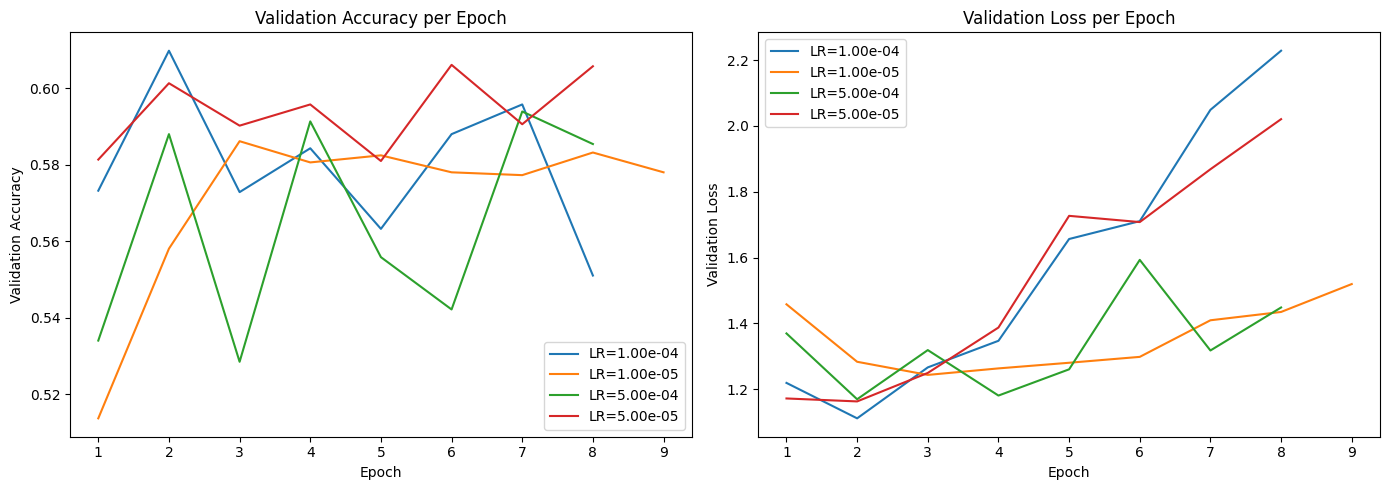

In [107]:
lr_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("lr_")])

# Prepare the plot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Plot validation accuracy
for d in lr_dirs:
    metrics_path = os.path.join(base_dir, d, "metrics.csv")
    if os.path.exists(metrics_path):
        df = pd.read_csv(metrics_path)
        lr = df["lr_sched"].iloc[0]
        axes[0].plot(df["epoch"], df["val_acc"], label=f"LR={lr:.2e}")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_title("Validation Accuracy per Epoch")
axes[0].legend()

# Plot validation loss
for d in lr_dirs:
    metrics_path = os.path.join(base_dir, d, "metrics.csv")
    if os.path.exists(metrics_path):
        df = pd.read_csv(metrics_path)
        lr = df["lr_sched"].iloc[0]
        axes[1].plot(df["epoch"], df["val_loss"], label=f"LR={lr:.2e}")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")
axes[1].set_title("Validation Loss per Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

We can see that the trial that achieves the lowest validation loss (which is our optimization criterion) is the one corresponding to a learning rate of 10^-4. We see that it reaches peak performance very early in training and then finds worse metrics in later epochs probably due to over-fitting. We can also wee that this applies also to other trials

In the next step we do a similar visualization comparing the tested schedulers and the no schedule training all together.

Best LR from phase1: 1e-04


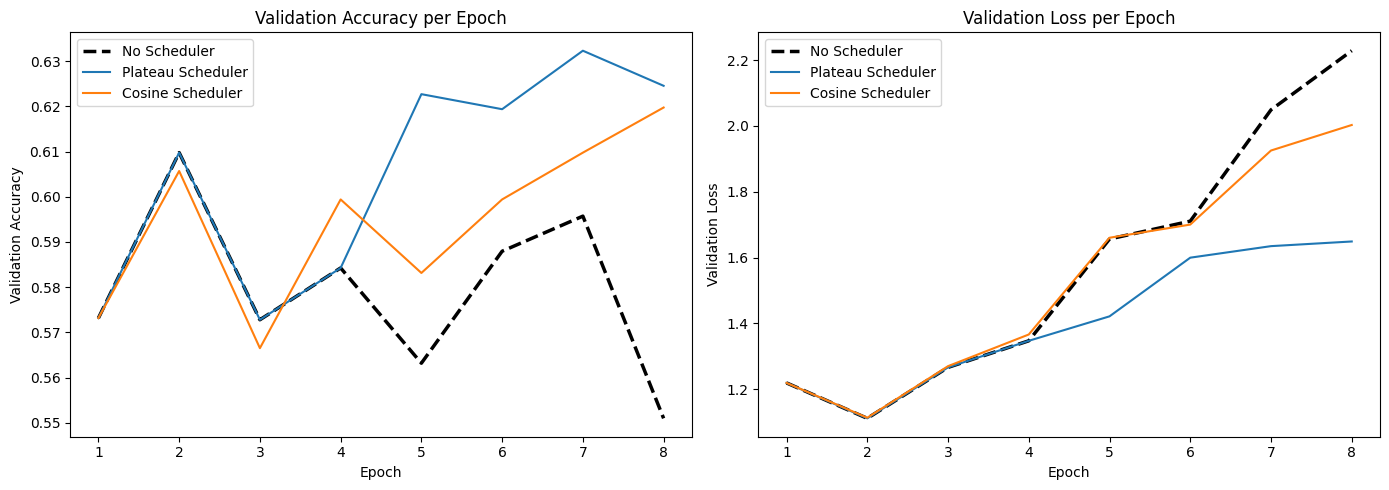

In [110]:
best_lr = phase1["lr"]

print(f"Best LR from phase1: {best_lr:.0e}")

# No scheduler dataframe
no_sched_df = None
for d in os.listdir(base_dir):
    if d.startswith("lr_"):
        df = pd.read_csv(os.path.join(base_dir, d, "metrics.csv"))
        if float(df["lr_sched"].iloc[0]) == best_lr and df["scheduler_type"].iloc[0] == "none":
            no_sched_df = df.copy()
            break

# For the schedulers
sched_dfs = {}
for d in os.listdir(base_dir):
    if d.startswith("sched_"):
        df = pd.read_csv(os.path.join(base_dir, d, "metrics.csv"))
        sched = df["scheduler_type"].iloc[0]
        sched_dfs[sched] = df.copy()

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# ACCURACY
axes[0].plot(
    no_sched_df["epoch"],
    no_sched_df["val_acc"],
    label=f"No Scheduler",
    linestyle="--",
    linewidth=2.5,
    color="black"
)
for sched, df in sched_dfs.items():
    axes[0].plot(
        df["epoch"],
        df["val_acc"],
        label=f"{sched.capitalize()} Scheduler"
    )
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_title("Validation Accuracy per Epoch")
axes[0].legend()

# LOSS
axes[1].plot(
    no_sched_df["epoch"],
    no_sched_df["val_loss"],
    label=f"No Scheduler",
    linestyle="--",
    linewidth=2.5,
    color="black"
)
for sched, df in sched_dfs.items():
    axes[1].plot(
        df["epoch"],
        df["val_loss"],
        label=f"{sched.capitalize()} Scheduler"
    )
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")
axes[1].set_title("Validation Loss per Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()


In this case we observe how the "plateau" scheduler trial moves closer to the "no scheduler" trial at the beginning but then later on achieves better performance generally. The same happens for the "cosine" scheduler, but in a more moderate way. However, even though the plateau scheduler peaks in accuracy in later epochs, this doesn't happen for the validation loss which increases after the peak low at epoch 2 

In the next plot we visualize the learning rate decreasing behavior of every scheduler to see if it works correctly:

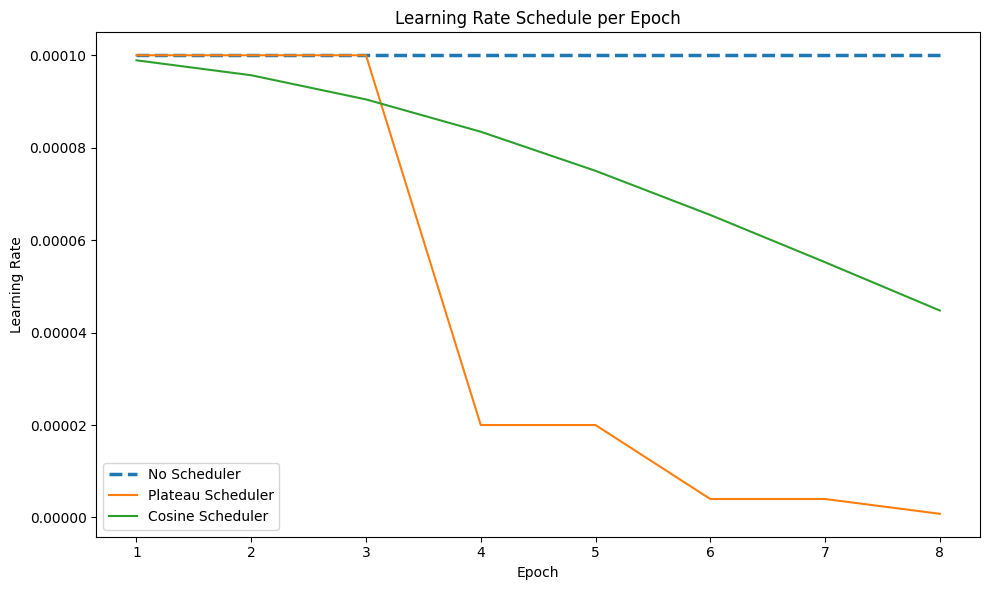

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# No scheduler
if no_sched_df is not None:
    plt.plot(
        no_sched_df["epoch"],
        no_sched_df["lr_sched"],
        label=f"No Scheduler",
        linestyle="--",
        linewidth=2.5
    )

# Cada scheduler
for sched, df in sched_dfs.items():
    plt.plot(
        df["epoch"],
        df["lr_sched"],
        label=f"{sched.capitalize()} Scheduler"
    )

plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule per Epoch")
plt.legend()
plt.tight_layout()
plt.show()


We can note that every scheduler behaves correctly in the specified manner as it should.

Lastly, we will plot the training and validation loss and accuracy of the best run in order to depict how over-fitting acts upon our model while training. We also generate a table to store the best metric we could achieve for every trial for comparison.

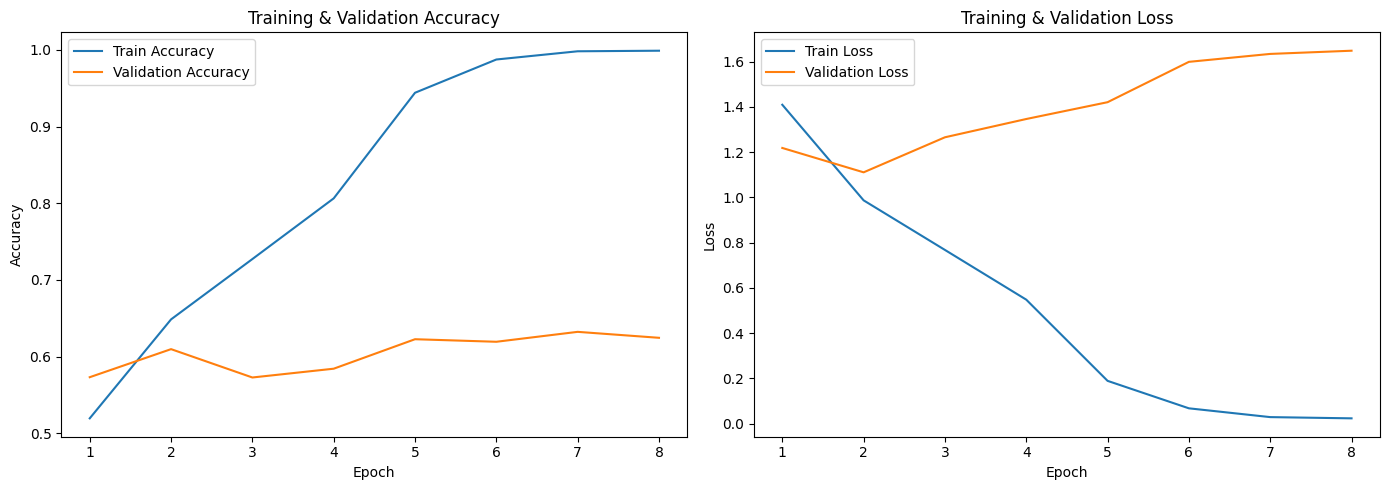

      Hyperparameter  Best Val Loss
0          LR=0.0001       1.111204
1           LR=1e-05       1.243211
2          LR=0.0005       1.169223
3           LR=5e-05       1.162642
4   Cosine Scheduler       1.113109
5  Plateau Scheduler       1.111204


In [111]:
best_sched = phase2["scheduler"]

# Locate
sched_dirs = [d for d in os.listdir(base_dir) if d.startswith(f"sched_{best_sched}")]
best_sched_dir = os.path.join(base_dir, sched_dirs[0])

df_final = pd.read_csv(os.path.join(best_sched_dir, "metrics.csv"))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(df_final["epoch"], df_final["train_acc"], label="Train Accuracy")
axes[0].plot(df_final["epoch"], df_final["val_acc"], label="Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training & Validation Accuracy")
axes[0].legend()

# Loss
axes[1].plot(df_final["epoch"], df_final["train_loss"], label="Train Loss")
axes[1].plot(df_final["epoch"], df_final["val_loss"], label="Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training & Validation Loss")
axes[1].legend()

plt.tight_layout()
plt.show()


records = []
# best val_loss for each learning rate
for d in sorted(os.listdir(base_dir)):
    if d.startswith("lr_"):
        df = pd.read_csv(os.path.join(base_dir, d, "metrics.csv"))
        lr = df["lr_sched"].iloc[0]
        best_val_loss = df["val_loss"].min()
        records.append({"Hyperparameter": f"LR={lr}", "Best Val Loss": best_val_loss})

# best val_loss for each scheduler
for d in sorted(os.listdir(base_dir)):
    if d.startswith("sched_"):
        df = pd.read_csv(os.path.join(base_dir, d, "metrics.csv"))
        sched = df["scheduler_type"].iloc[0]
        best_val_loss = df["val_loss"].min()
        records.append({"Hyperparameter": f"{sched.capitalize()} Scheduler", "Best Val Loss": best_val_loss})

summary_df = pd.DataFrame(records)

# Display the summary table
print(summary_df)

We can see that while train accuracy and loss get better overtime in a steady manner, the validation metrics don't behave in the same way. This illustrates the problem of over-fitting. Lastly, we can see that the final hyper-parameter configuration corresponds exactly to the findings in validation loss. i.e. the lowest validation loss parameters are exactly the ones chosen by the algorithm